<a href="https://colab.research.google.com/github/SofiaE24/Anomaly-Detection/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyOD

In [ ]:
!pip install pyod
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.2 MB/s eta 0:00:00


In [ ]:
#Librerias
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from pyod.models.lof import LOF
import numpy as np


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Dense

import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose



In [ ]:
# Carga y manipulación de datos desde un archivo Excel
df = pd.read_excel('/content/Colombia_Demanda_Horaria.xlsx')
df.set_index('Date', inplace=True)
df.head(-1)


,Demand
Date,
2000-01-01 00:00:00.000,4524870.45
2000-01-01 01:00:00.000,4194491.52
2000-01-01 02:00:00.000,3768572.52
2000-01-01 03:00:00.000,3474891.84
2000-01-01 04:00:00.000,3275226.20
...,...
2022-12-31 17:59:59.958,8923913.77
2022-12-31 18:59:59.958,8908315.14
2022-12-31 19:59:59.958,8523440.52


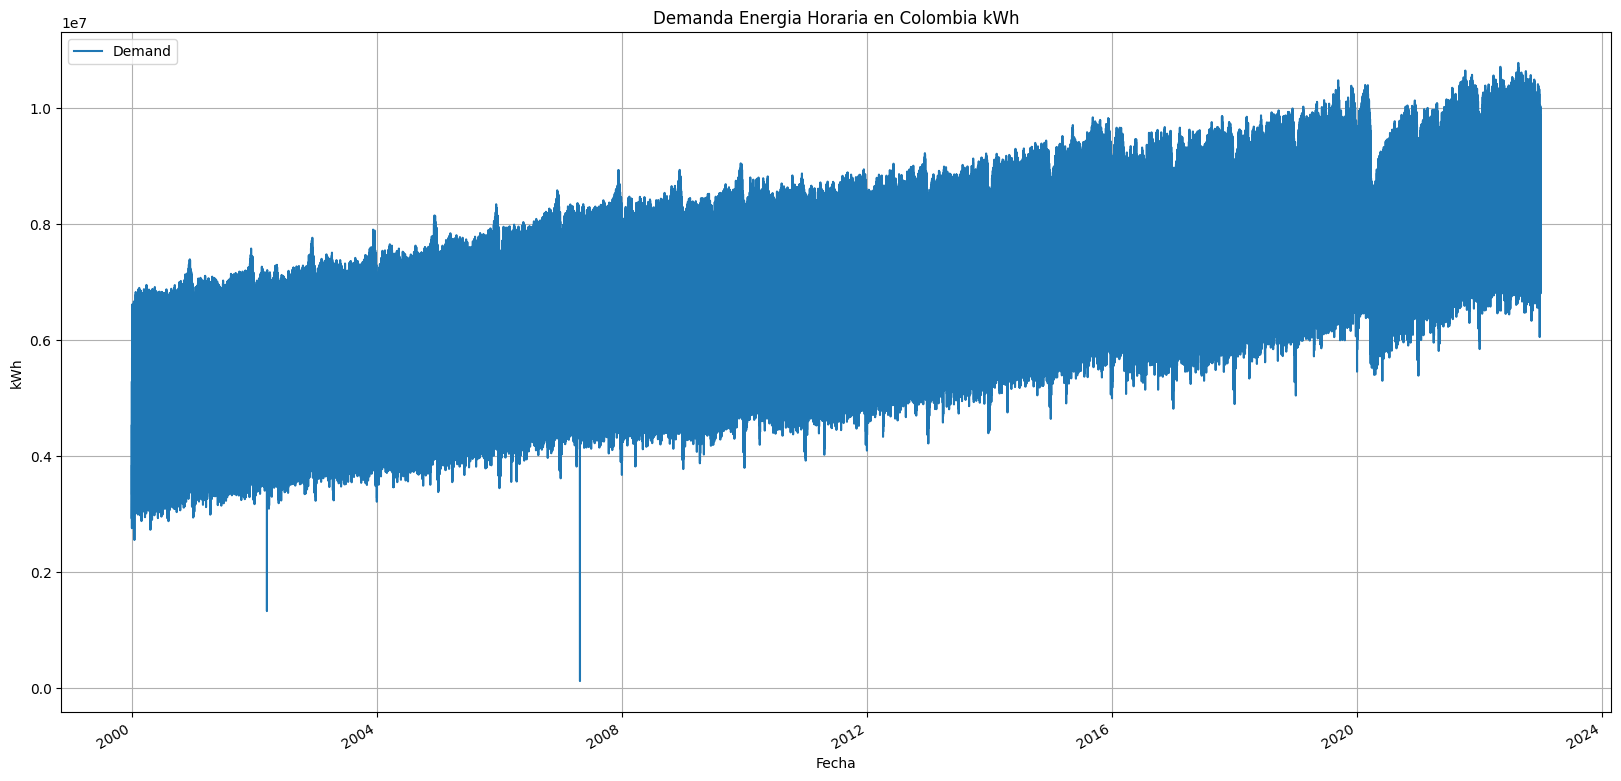

In [ ]:
# Visualización de una gráfica de línea

# Configurar el tamaño de la figura
fig, ax = plt.subplots(figsize=(20, 10))

# Crear una gráfica de línea en base a los datos del DataFrame 'df'
df.plot(kind='line', ax=ax, title='Demanda Energia Horaria en Colombia kWh', grid=True, ylabel='kWh', xlabel='Fecha')

# Mostrar la gráfica
plt.show()



In [ ]:
df.describe()

,Demand
count,2.016240e+05
mean,6.611514e+06
std,1.597394e+06
min,1.195172e+05
25%,5.394409e+06
50%,6.574479e+06
75%,7.803537e+06
max,1.078689e+07


Epoch 1/100
5041/5041 [==============================] - 17s 3ms/step - loss: 0.0143 - val_loss: 1.2475e-06
Epoch 2/100
5041/5041 [==============================] - 13s 3ms/step - loss: 2.9484e-06 - val_loss: 1.3029e-07
Epoch 3/100
5041/5041 [==============================] - 12s 2ms/step - loss: 3.7072e-06 - val_loss: 1.0087e-06
Epoch 4/100
5041/5041 [==============================] - 11s 2ms/step - loss: 3.6731e-06 - val_loss: 6.7050e-08
Epoch 5/100
5041/5041 [==============================] - 12s 2ms/step - loss: 3.3212e-06 - val_loss: 4.0883e-07
Epoch 6/100
5041/5041 [==============================] - 12s 2ms/step - loss: 3.7391e-06 - val_loss: 3.0834e-08
Epoch 7/100
5041/5041 [==============================] - 15s 3ms/step - loss: 2.9164e-06 - val_loss: 7.3601e-06
Epoch 8/100
5041/5041 [==============================] - 13s 3ms/step - loss: 2.6298e-06 - val_loss: 1.9383e-06
Epoch 9/100
5041/5041 [==============================] - 16s 3ms/step - loss: 3.3494e-06 - val_loss: 3.3895e

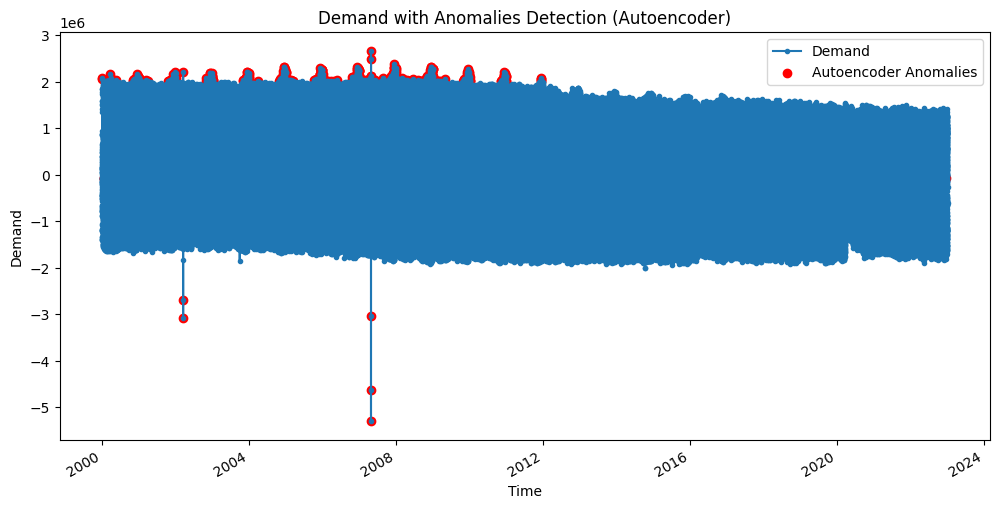

In [ ]:
# Load data from Excel
df2 = pd.read_excel('/content/Colombia_Demanda_Horaria.xlsx')

# Convert the 'Date' column to a datetime format
df2['Date'] = pd.to_datetime(df2['Date'])

# Set the 'Date' column as the index
df2.set_index('Date', inplace=True)

# Handle missing values with interpolation
df2_interpolated = df2.interpolate(method="time")

# Remove trend using STL algorith
stl2 = STL(df2_interpolated['Demand'], period=24)
res2 = stl2.fit()
df2_detrended = df2_interpolated - res2.trend.values.reshape(-1, 1)

# Scale the data for the autoencoder
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df2_detrended[['Demand']])

# Split the data into training and testing sets
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

# Define the autoencoder model
input_layer = Input(shape=(1,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(1, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

# Reconstruct the data using the trained autoencoder
df_reconstructed = pd.DataFrame(autoencoder.predict(df_scaled), columns=['Demand'])
df_reconstructed.index = df2_detrended.index

# Calculate the reconstruction error
reconstruction_error = ((df_scaled - autoencoder.predict(df_scaled)) ** 2).mean(axis=1)

# Set a threshold for anomaly detection
threshold = reconstruction_error.mean() + 2.3 * reconstruction_error.std()

# Mark anomalies
df2_detrended['autoencoder_anomaly'] = reconstruction_error > threshold

# Plot the series with autoencoder anomalies
plt.figure(figsize=[12, 6])
df2_detrended['Demand'].plot(style='.-', label='Demand')
plt.scatter(df2_detrended[df2_detrended['autoencoder_anomaly']].index,
            df2_detrended[df2_detrended['autoencoder_anomaly']]['Demand'],
            color='red',
            label='Autoencoder Anomalies')

# Add labels and title
plt.title("Demand with Anomalies Detection (Autoencoder)")
plt.ylabel("Demand")
plt.xlabel("Time")
plt.legend()
plt.show()


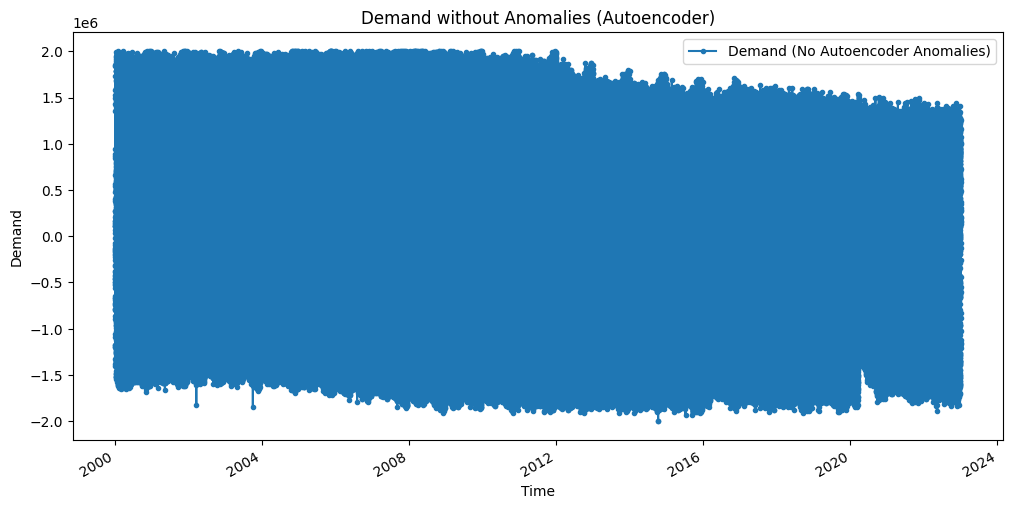

In [ ]:
# Filter out autoencoder anomalies
df2_no_autoencoder_anomalies = df2_detrended[df2_detrended['autoencoder_anomaly'] == False]

# Plot the series without autoencoder anomalies
plt.figure(figsize=[12, 6])
df2_no_autoencoder_anomalies['Demand'].plot(style='.-', label='Demand (No Autoencoder Anomalies)')

# Add labels and title
plt.title("Demand without Anomalies (Autoencoder)")
plt.ylabel("Demand")
plt.xlabel("Time")
plt.legend()
plt.show()


In [ ]:
from matplotlib import pyplot
from matplotlib import rcParams

rcParams['figure.figsize'] = 11.7,8.27 # A4 format - [inches]
rcParams['lines.markersize'] = 6       # marker size in points
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

from tslearn.clustering import TimeSeriesKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.impute import SimpleImputer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [ ]:
# Carga y manipulación de datos desde un archivo Excel

# Cargar el archivo Excel 'Demanda_Arreglo_Mean.xlsx' en un DataFrame 'df'
df = pd.read_excel('/content/Demanda_Arreglo_Mean.xlsx')

# Establecer la columna 'Date' como índice en el DataFrame 'df'
df.set_index('Date', inplace=True)
df.head(-1)


,Colombia,Bogota,Caribe Mar,Antioquia,Caribe Sol,Cali,Santander,Boyaca,Valle del Cauca,Meta,...,Cauca,Nariño,Pereira,Casanare,Quindio,Choco,Tulua,Cartago,Costa Caribe,Valle del Sibundoy
Date,,,,,,,,,,,,,,,,,,,,,
2020-09-30 23:59:59.962,7140559.26,1320792.69,1224290.37,899450.34,1090389.39,414176.69,350902.86,278981.87,264640.87,157696.69,...,98578.43,63232.62,56584.97,54231.09,42546.54,24259.00,22226.42,18485.01,4134.73,956.50
2020-10-01 00:59:59.962,6889229.54,1265863.83,1188898.49,852134.53,1053745.78,397509.19,338021.81,291912.15,258723.10,154469.65,...,95748.21,58963.14,53894.29,52937.00,39641.78,21787.79,21468.45,17933.59,4100.38,887.62
2020-10-01 01:59:59.962,6768128.26,1242928.76,1164769.75,843323.57,1022801.61,386700.22,333269.26,304934.61,250411.11,152529.17,...,93315.29,57276.91,52370.15,50573.76,38634.57,23169.62,20459.32,17417.63,4069.11,853.63
2020-10-01 02:59:59.962,6701299.05,1260574.75,1132657.87,848113.38,992043.52,380463.87,324627.44,309025.29,248248.85,153509.13,...,94824.47,57305.74,52095.61,49493.68,38229.84,21423.47,20267.58,17464.35,4065.57,839.21
2020-10-01 03:59:59.962,6806767.20,1325971.00,1120738.54,888338.01,975121.31,384215.95,321360.54,317756.70,252769.41,154665.14,...,99061.18,60415.12,53296.95,49035.41,39145.05,21137.06,19941.27,17853.03,4051.39,885.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 17:59:59.958,8923913.77,1716030.60,1354149.86,1196099.22,1083044.88,417479.87,443201.44,415440.23,288716.77,394568.67,...,129147.94,120701.93,85187.32,74533.46,74162.61,32967.93,29704.03,22965.06,11341.84,1908.55
2022-12-31 18:59:59.958,8908315.14,1684451.43,1357901.50,1170563.26,1089049.32,420256.38,440737.66,415446.21,300430.99,393999.19,...,133492.59,126064.59,83567.23,73987.24,73895.22,33919.83,30488.61,22737.66,11303.54,2016.91
2022-12-31 19:59:59.958,8523440.52,1596077.54,1305581.21,1105249.12,1053903.62,402457.48,420362.13,399837.12,289644.00,388279.78,...,129098.94,116102.61,79505.56,70900.51,69885.98,32469.87,28857.69,21266.53,11214.87,1846.60


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19728 entries, 2020-09-30 23:59:59.962000 to 2022-12-31 22:59:59.958000
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Colombia             19728 non-null  float64
 1   Bogota               19728 non-null  float64
 2   Caribe Mar           19728 non-null  float64
 3   Antioquia            19728 non-null  float64
 4   Caribe Sol           19728 non-null  float64
 5   Cali                 19728 non-null  float64
 6   Santander            19728 non-null  float64
 7   Boyaca               19728 non-null  float64
 8   Valle del Cauca      19728 non-null  float64
 9   Meta                 19728 non-null  float64
 10  Norte de Sanatender  19728 non-null  float64
 11  Caldas               19728 non-null  float64
 12  Tolima               19728 non-null  float64
 13  Huila                19728 non-null  float64
 14  Cauca                19728 non-null  

In [ ]:
df.fillna(df.mean(), inplace=True)

In [ ]:
df.describe()

,Colombia,Bogota,Caribe Mar,Antioquia,Caribe Sol,Cali,Santander,Boyaca,Valle del Cauca,Meta,...,Cauca,Nariño,Pereira,Casanare,Quindio,Choco,Tulua,Cartago,Costa Caribe,Valle del Sibundoy
count,1.972800e+04,1.972800e+04,1.972800e+04,1.972800e+04,1.972800e+04,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,...,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000,19728.000000
mean,8.520192e+06,1.807964e+06,1.219146e+06,1.185503e+06,1.084959e+06,466686.253226,404478.881664,382545.774393,297607.805125,241126.564176,...,118725.156032,98013.693317,78301.319537,65949.009244,59679.457872,29574.782567,27083.359705,22926.530593,18478.418195,1476.075680
std,1.093714e+06,3.357052e+05,1.207211e+05,2.103032e+05,1.050221e+05,90049.921783,58095.453927,43134.607242,42890.528684,42931.755896,...,20203.255991,23092.035719,16647.526556,10140.697160,13221.226402,5514.486243,5147.476119,4598.685197,4637.772815,424.663737
min,5.389560e+06,9.323532e+05,8.200898e+05,6.655529e+05,7.435277e+05,230292.470000,273547.250000,250470.700000,150879.650000,69241.370000,...,57368.720000,22987.180000,41426.100000,19236.070000,34369.780000,721.380000,10975.770000,5820.730000,334.010000,1.340000
25%,7.544031e+06,1.496971e+06,1.133439e+06,9.890094e+05,1.006931e+06,387911.067500,349145.052500,352816.957500,263498.635000,211564.645000,...,102148.172500,76115.875000,62028.442500,58117.160000,45813.272500,25074.640000,22345.570000,18802.190000,16128.320000,1094.820000
50%,8.592540e+06,1.851653e+06,1.217416e+06,1.199002e+06,1.088679e+06,460237.160000,407030.285000,381836.640000,297215.985000,234802.960000,...,120914.495000,105358.605000,78915.250000,65902.820000,62314.215000,30362.460000,27073.905000,22927.440000,18674.260000,1522.900000
75%,9.507811e+06,2.125857e+06,1.305449e+06,1.382209e+06,1.161113e+06,548786.922500,457124.092500,411522.805000,333971.752500,264663.655000,...,132537.840000,113206.272500,94126.175000,73933.610000,71361.767500,33448.482500,31595.925000,27203.895000,21526.457500,1698.575000
max,1.078689e+07,2.357194e+06,1.601461e+06,1.564164e+06,1.383224e+06,674006.860000,527920.810000,518485.300000,405763.410000,415640.860000,...,189113.070000,461849.760000,108883.020000,94536.780000,84428.180000,154800.600000,39683.090000,32790.120000,31110.880000,2741.200000


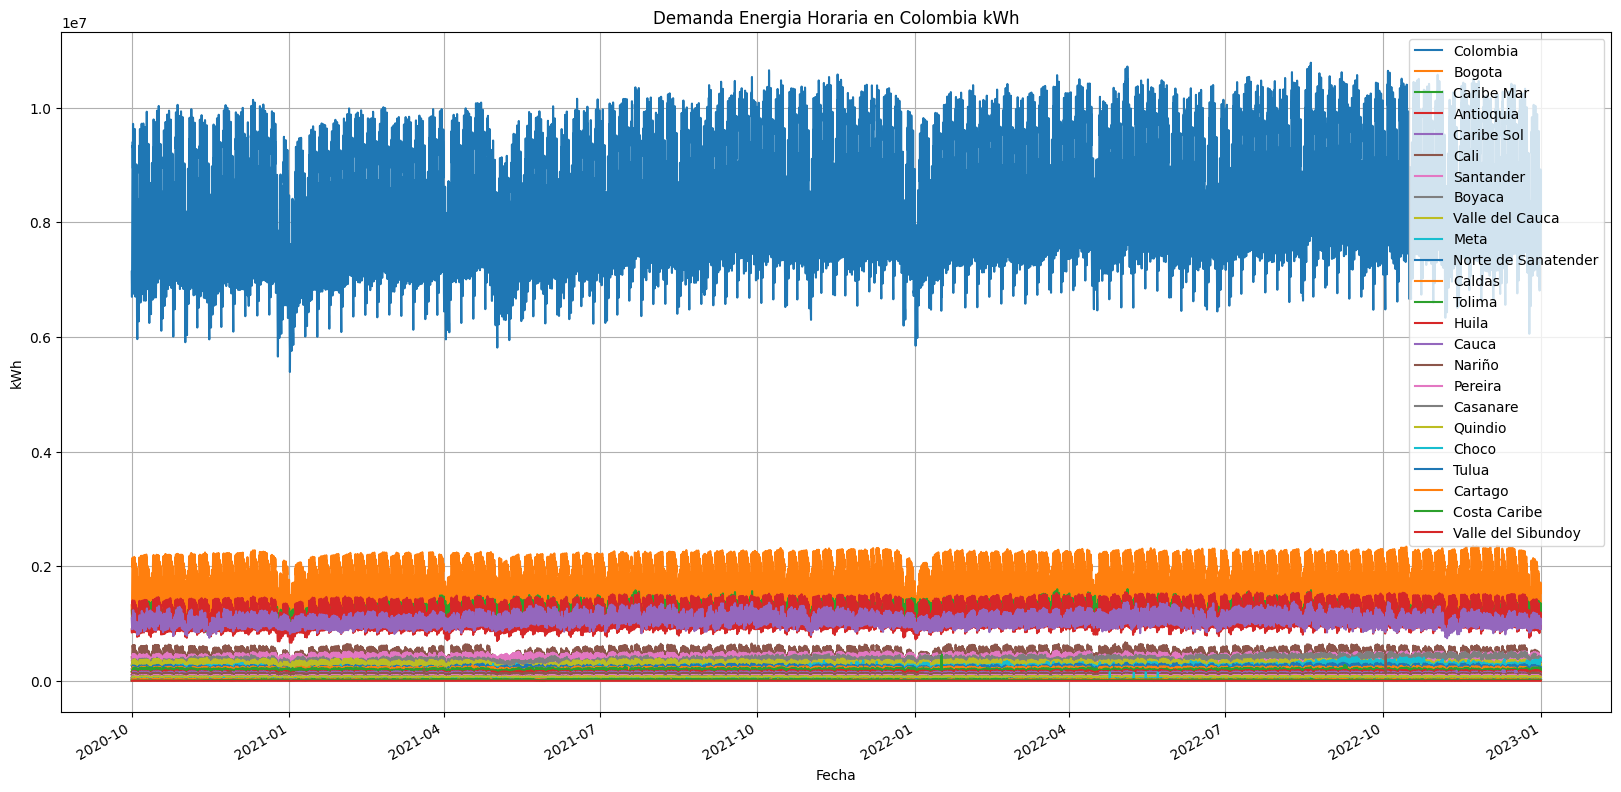

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
df.plot(kind='line', ax=ax, title='Demanda Energia Horaria en Colombia kWh', grid=True, ylabel='kWh', xlabel='Fecha')
plt.show()

## Standarization of the data

In [ ]:
estandar = StandardScaler()
df_est = pd.DataFrame(estandar.fit_transform(df),columns=df.columns)

In [ ]:
X = np.array(df_est).T
X = SimpleImputer().fit_transform(X)
X = np.expand_dims(X, axis = -1)
X = np.expand_dims(X, axis = 1)

In [ ]:
X.shape

(24, 1, 19728, 1)

## Model definition:


In [ ]:
stride = 1
model = keras.Sequential(
    [
        layers.Input(shape=(X.shape[1],X.shape[2], X.shape[3])),
        layers.Conv2D(
            filters=32, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2D(
            filters=64, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2D(
            filters=128, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2D(
            filters=128, kernel_size=(1,3), padding="same", strides=stride, activation="relu"
        ),
     layers.Dense(units = 384, activation = 'relu'),
     layers.Dense(units = 5, activation = 'relu'),
     layers.Dense(units = 384, activation = 'relu'),

        layers.Conv2DTranspose(
            filters=128, kernel_size=(1,3), padding="same", strides=stride, activation="relu"
        ),
        layers.Conv2DTranspose(
            filters=128, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2DTranspose(
            filters=64, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2DTranspose(
            filters=32, kernel_size=(10,1), padding="same", strides=stride, activation="relu"
        ),
     layers.Conv2DTranspose(
            filters=1, kernel_size=(1,1), padding="same", strides=stride, activation="relu"
        ),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 19728, 32)      352       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 19728, 64)      20544     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 19728, 128)     82048     
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 19728, 128)     49280     
                                                                 
 dense_12 (Dense)            (None, 1, 19728, 384)     49536     
                                                                 
 dense_13 (Dense)            (None, 1, 19728, 5)       1925      
                                                                 
 dense_14 (Dense)            (None, 1, 19728, 384)     2

## Model training

In [ ]:
history = model.fit(
    X,
    X,
    epochs=100,
    batch_size=5,
    validation_split=0.1,
)

Epoch 1/100
5/5 [==============================] - 44s 8s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 2/100
5/5 [==============================] - 35s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 3/100
5/5 [==============================] - 33s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 4/100
5/5 [==============================] - 34s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 5/100
5/5 [==============================] - 35s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 6/100
5/5 [==============================] - 34s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 7/100
5/5 [==============================] - 33s 6s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 8/100
5/5 [==============================] - 34s 6s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 9/100
5/5 [==============================] - 35s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 10/100
5/5 [==============================] - 33s 7s/step - loss: 1.0000 - val_loss: 1.0000
Epoch 11/100
5/5 [===========

<Axes: >

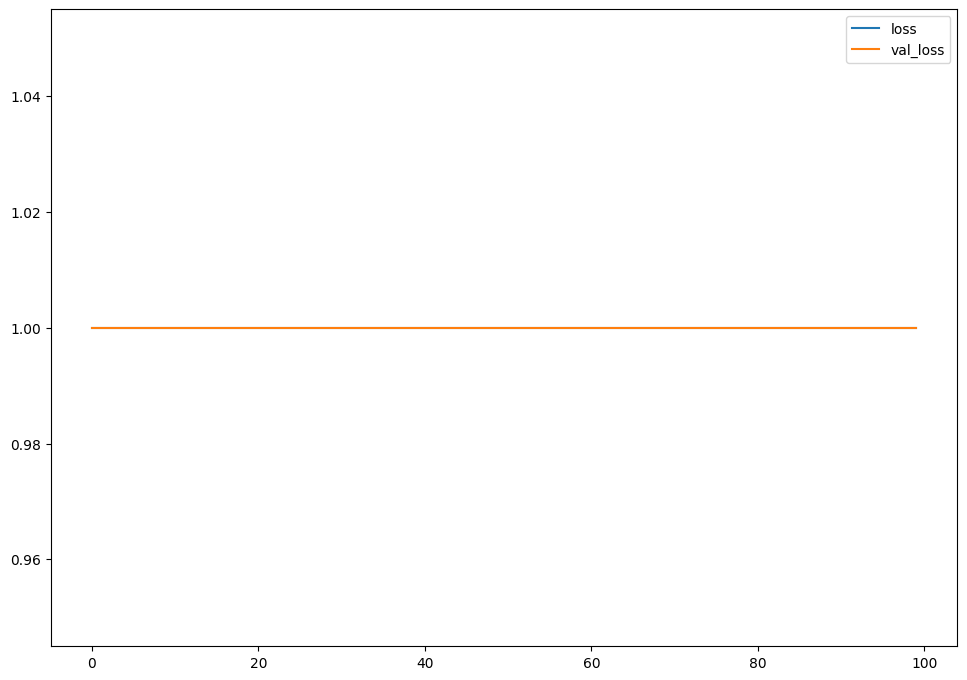

In [ ]:
pd.DataFrame(history.history).plot()

## Feature extraction (output of the dense layer)

In [ ]:
extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(X)[5]

features = np.array(features[:,0,:,:])
features = features.reshape((features.shape[0], -1))


## PCA to the extracted features

In [ ]:
n_clusters = 5

z = PCA().fit_transform(features)

## KMeans to the extracted features (after applying PCA)

In [ ]:
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(z)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


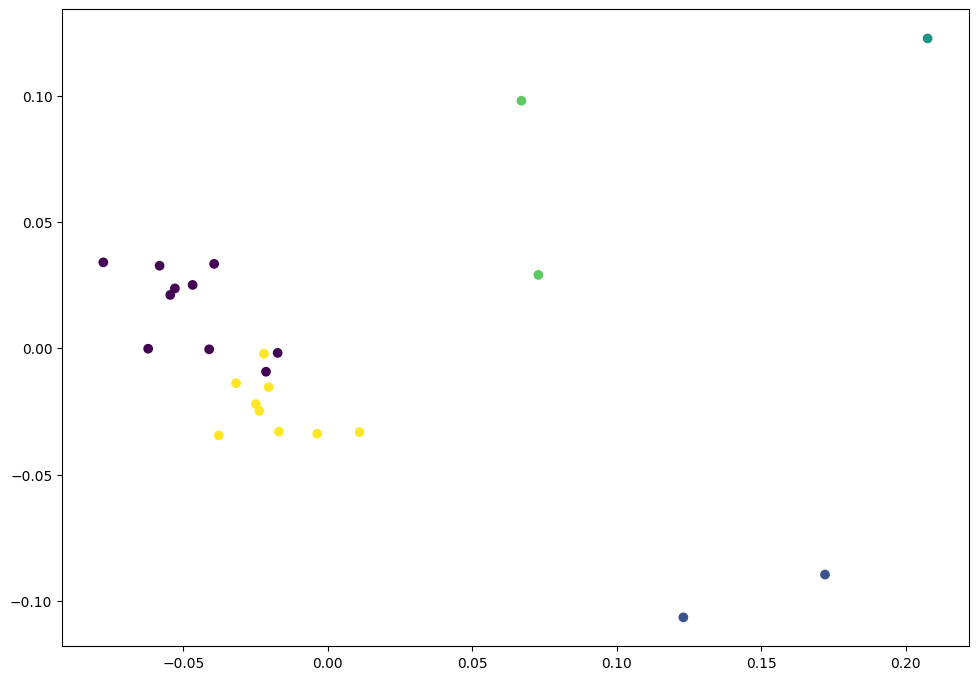

In [ ]:
plt.scatter(z[:,0], z[:,1], c=kmeans.labels_)

## Results visualization

In [ ]:
clusters = kmeans.labels_

series = df.columns

for cluster in np.unique(clusters):
  print(f"Cluster {cluster}:")
  print(list(series[clusters==cluster]))

Cluster 0:
['Colombia', 'Bogota', 'Antioquia', 'Valle del Cauca', 'Caldas', 'Cauca', 'Nariño', 'Pereira', 'Quindio', 'Valle del Sibundoy']
Cluster 1:
['Caribe Mar', 'Caribe Sol']
Cluster 2:
['Costa Caribe']
Cluster 3:
['Boyaca', 'Meta']
Cluster 4:
['Cali', 'Santander', 'Norte de Sanatender', 'Tolima', 'Huila', 'Casanare', 'Choco', 'Tulua', 'Cartago']


In [ ]:
import matplotlib.colors as mcolors

colors = list(mcolors.TABLEAU_COLORS.keys())

line_colors = []

for color in kmeans.labels_:
  line_colors.append(colors[color])

Cluster:  0


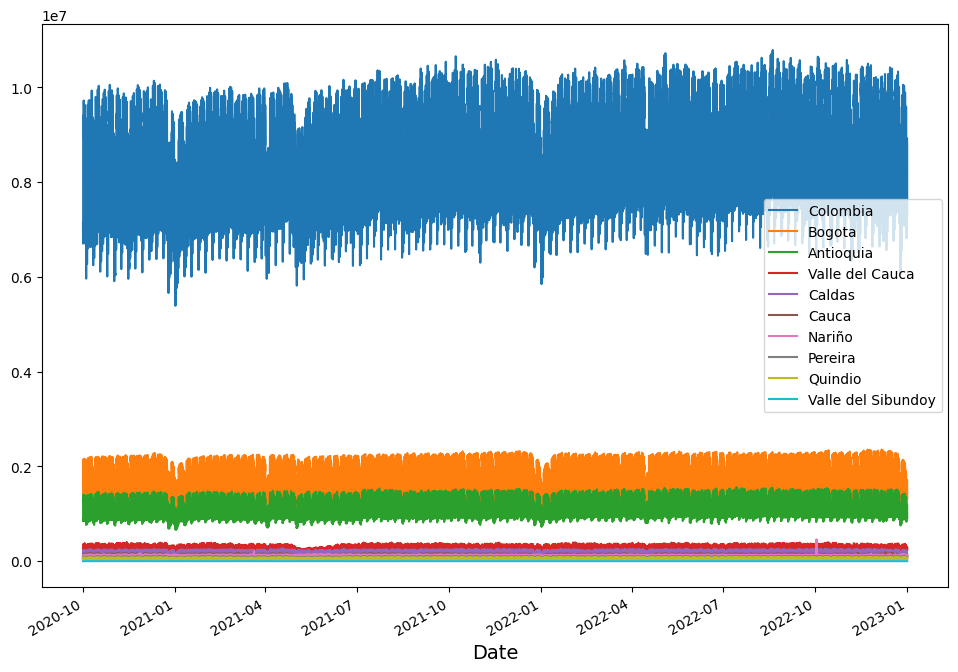

Cluster:  1


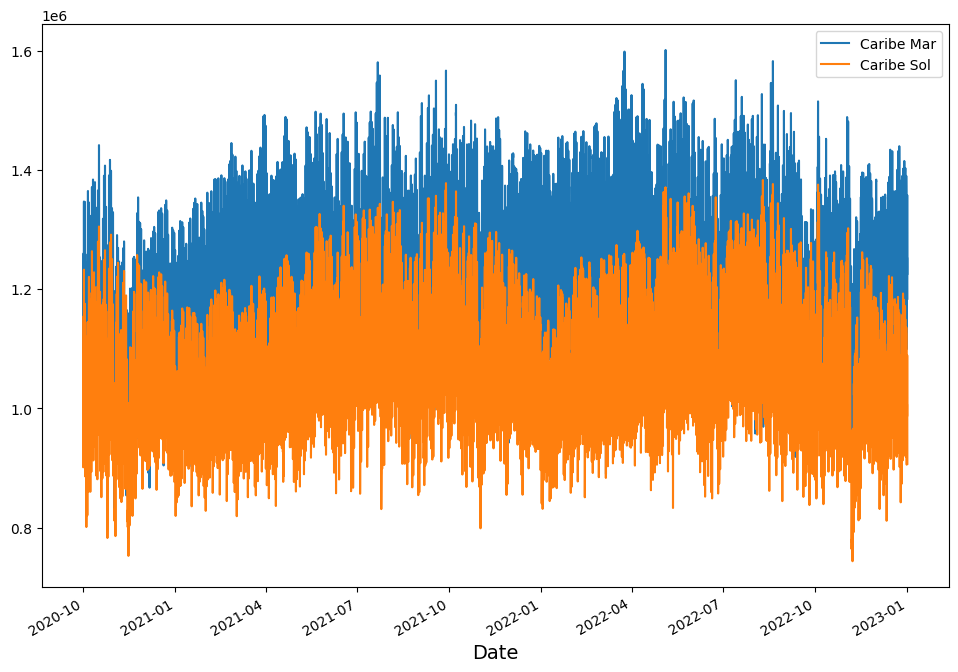

Cluster:  2


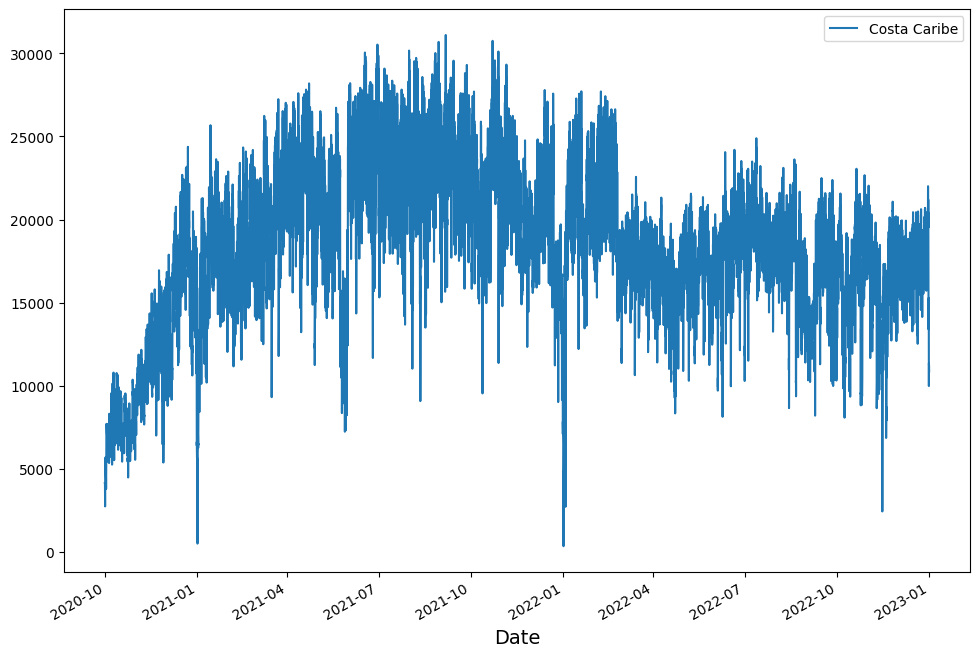

Cluster:  3


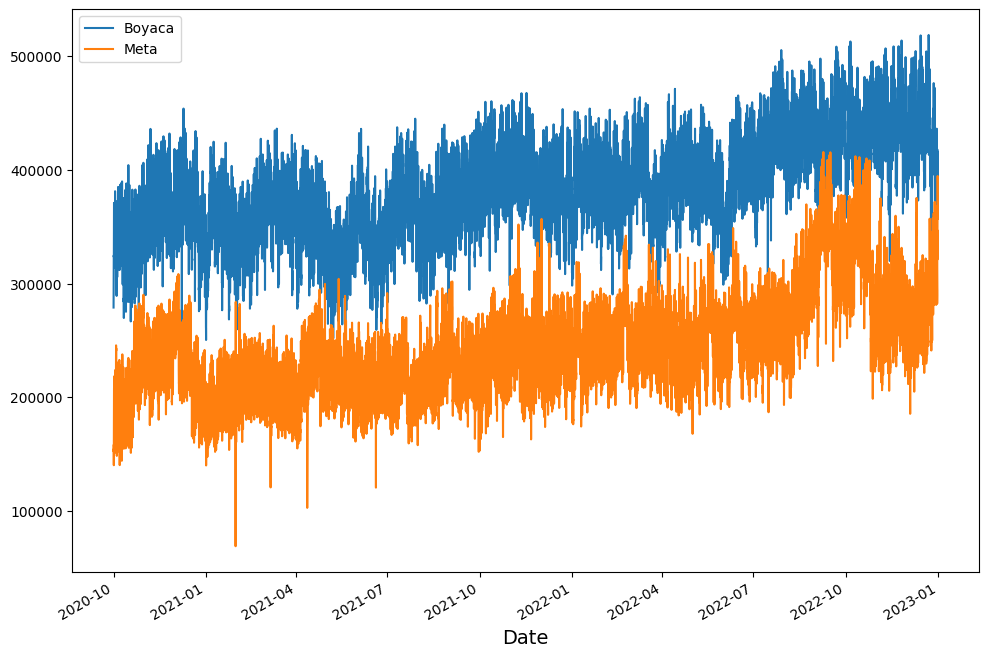

Cluster:  4


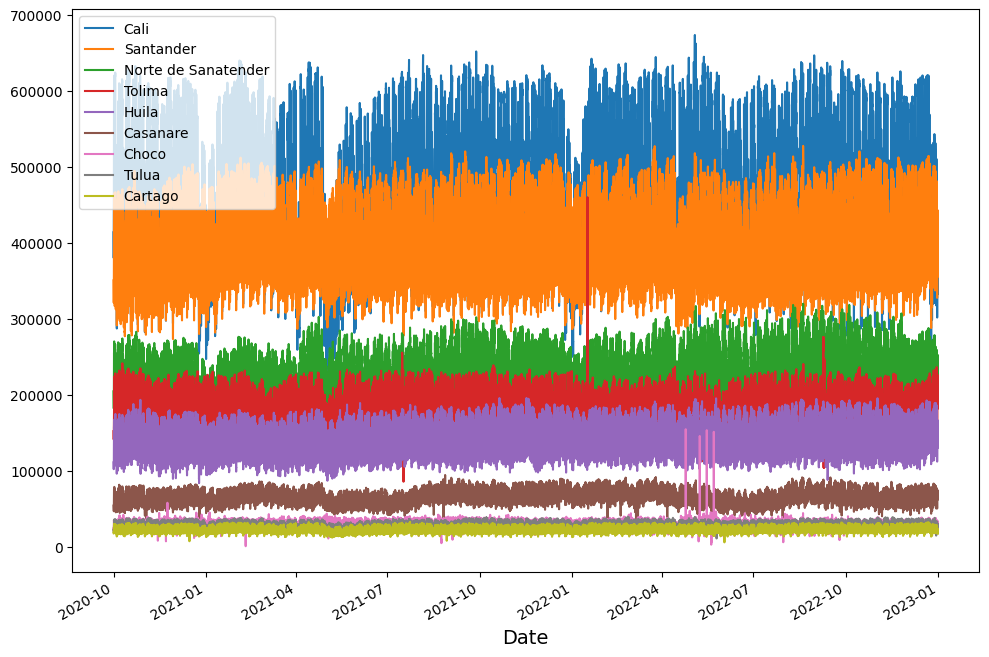

In [ ]:
for cluster in np.unique(clusters):
  columns = series[clusters==cluster]
  print("Cluster: ",cluster)
  df[columns].plot()
  plt.show()